# Introduction

Citibike is the leading bikesharing platform in New York, including the districts of Manhattan, Brooklyn, Queens & Jersey City. That said, the company is far from being profitable due to growing competition from other modes of transportation (e.g., scooters, electric bikes, etc.). According to a consulting firm hired a few months ago, the operations of Citibike are inefficient due to the lack of data-driven technology. If Citibike were only 4\% more efficient, it would become profitable. During peak hours (e.g., morning commute time), the bikesharing platform is particularly unreliable. Approximately 20\% of the dock stations face a "stock-out" situation, meaning that there are no bikes available. In such cases, commuters choose other modes of transportation. 

<img src="citi-bike.jpg" width="500">

### Description
The consulting firm recommends using **optimization models** to improve the operations, especially during peak time. As part of this new strategy, let's say I am recently hired as a lead data scientist of Citibike. I suspect that the inventory of bikes and the dock stations are not well positioned given the incoming demand at peak times. In this project, I will develop a data-driven optimization model to improve the positioning of inventory at peak time. In particular, I will formulate and implement integer programming models.

# 1. Data Visualisation

## 1.1. Load the data

The colleague of mine has generated data sets that contains all the needed information about the demand and available inventory of bikes during *one hour at peak time*. The initial analysis will be based on the following data sets:

- `demand.csv`: describes the number of bikes rented at each dock station (during one peak hour),
- `starting_inventory.csv`: describes the initial inventory of bikes at each dock station (before peak hour),
- `distances.csv`: describes the distance between any two dock stations (in km unit).


Ideally, the inventory of bikes available the beginning of the peak hour should approximately match the expected amount of demand. For example, if you expect 5 user requests in station A, and 5 user requests in station B in the next hour, the number of bikes in station A and B should be roughly equal, otherwise there is an imbalance of inventory. Using spatial visualization, I will check if the initial inventory is balanced or imbalanced.


In [1]:
# Import various packages
import pandas as pd
import numpy as np
import folium # visualisation package for spatial data (plot of maps)
import seaborn as sns # general visualization package 
import matplotlib.pyplot as plt # general visualization package 
#next command allows to display the figures in the notebook
%matplotlib inline     

In [2]:
## In case folium is not installed, run the command below and import folium again
# ! conda install -c conda-forge folium --yes

Next, let's load the data sets as dataframes using the Pandas function `pd.read_csv()`.

In [2]:
starting_inventory = pd.read_csv("starting_inventory.csv", index_col=0) 
# "index_col=0" is used so that the dataframe is indexed by the first column
demand = pd.read_csv("demand.csv", index_col=0)
distances = pd.read_csv("distances.csv", index_col=0)
distances.columns = list(map(lambda x: int(x),distances.columns.tolist())) # the column names are converted into integers


Using the command `.describe()`, we can familiarize with the format of the dataframes, and  check if there are missing entries.

In [4]:
demand.describe()

,latitude,longitude,count
count,689.000000,689.000000,689.000000
mean,40.732527,-73.967780,27.648766
std,0.041163,0.024024,56.377839
min,40.655400,-74.025353,1.000000
25%,40.695807,-73.987030,5.000000
50%,40.728419,-73.968044,10.000000
75%,40.767100,-73.949450,26.000000
max,40.814394,-73.910651,428.000000


In [5]:
demand.head()

,latitude,longitude,count
station_id,,,
119,40.696089,-73.978034,10
120,40.686768,-73.959282,6
127,40.731724,-74.006744,134
143,40.692395,-73.993379,34
144,40.698399,-73.980689,10


In [6]:
distances.describe()

,119,120,127,143,144,146,150,157,161,167,...,534,536,539,540,545,546,72,79,82,83
count,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,...,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000
mean,5.234788,5.818614,5.660433,5.815784,5.173995,5.896868,4.557984,6.009891,5.136558,4.691174,...,6.487351,4.529948,4.646942,4.676314,4.500302,4.725332,5.935885,5.695771,5.451519,5.886057
std,3.101918,3.240807,2.416317,3.396272,3.039626,2.765462,2.232180,3.456671,2.369193,2.011353,...,3.129782,1.880601,2.148153,2.001787,1.912251,2.026796,2.523133,2.677876,2.832379,3.535927
min,0.000000,0.000000,0.000000,0.000135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.778453,3.166575,3.980364,2.922870,2.795046,3.792634,2.907156,3.077351,3.575707,3.018884,...,3.896037,3.009274,3.131241,3.093796,2.985554,3.137539,4.043380,3.715493,3.254939,3.078088
50%,4.243954,5.492614,5.792542,5.194791,4.199160,5.789344,4.364615,5.426828,5.290044,4.733095,...,6.257024,4.590299,4.426917,4.846375,4.599683,4.905780,5.945542,5.633804,5.191993,5.067243
75%,7.926693,8.437574,7.444620,8.712969,7.752457,7.900162,5.982674,8.953698,6.833613,6.320707,...,8.895602,6.124998,6.031318,6.364107,6.043458,6.460421,8.018556,7.575516,7.511705,8.959315
max,12.087375,12.776908,10.356681,12.864326,11.919733,11.534052,9.753680,13.111354,9.844240,9.969009,...,12.871711,9.299113,9.929280,9.222172,8.738407,9.322635,11.311183,11.157840,11.482100,13.259187


In [7]:
distances.head()

,119,120,127,143,144,146,150,157,161,167,...,534,536,539,540,545,546,72,79,82,83
location_id,,,,,,,,,,,,,,,,,,,,,
119,0.000000,2.094147,4.576156,1.578340,0.351894,3.703925,2.494454,1.882099,3.869203,5.284849,...,3.528586,4.543318,2.622010,4.720622,4.041264,4.861771,7.293577,3.674261,2.678328,1.238214
120,2.094147,0.000000,6.537415,3.455861,2.436309,5.789344,4.035755,3.707200,5.748911,6.435531,...,5.572353,5.699120,2.859642,6.081263,5.317338,6.238080,8.764337,5.737332,4.761456,1.729366
127,4.576156,6.537415,0.000000,4.153819,4.230192,1.565336,2.806855,4.219027,0.901155,3.517445,...,2.978002,3.285418,4.930235,2.710110,2.904528,2.690806,3.778741,1.260900,2.157752,5.674226
143,1.578340,3.455861,4.153819,0.000135,1.403859,2.857265,3.110962,0.312868,3.707730,5.910346,...,2.184809,5.225369,4.031096,5.194791,4.668016,5.307196,7.487916,2.984197,1.996774,1.908738
144,0.351894,2.436309,4.230192,1.403859,0.000000,3.355853,2.247528,1.716283,3.535663,5.071439,...,3.230217,4.337345,2.655934,4.474058,3.819127,4.610999,7.013423,3.322657,2.329233,1.521284


### Comment (1)

*The distance between the dock stations "120" and "146" is 5.789344. The maximum inventory of bikes available over all dock station is 428 as we can see from the result of describe function above.*


## 1.2. Plot the heatmaps of demand and inventory

In the next cells, we will generate a heatmap of New York, representing the level of demand in different regions.

In [3]:
def generateBaseMap(default_location=[40.71, -73.96], default_zoom_start=12.5):
    '''
    This function generates a base map using the folium package
    
    Arguments:
    default_location -> latitude, longitude (a list)
    default_zoom_start -> level of zoom of the map (a positive number)
    '''
    base_map = folium.Map(location=default_location,control_scale=True, zoom_start=default_zoom_start)
    # 'Stamen Toner' is a type of map; by default the map is "OpenStreetMap"
    return base_map

The next cell will plot a heatmap of the demand.

In [4]:
# Import the HeatMap object constructor from the folium package
from folium.plugins import HeatMap 

# To begin, generate a base map, which will be edited next
base_map = generateBaseMap()

# The demand is converted into a list of t-uples, each describing one request point: (longitude, latitude, count)
demand_agg= demand[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum()
demand_list = demand_agg.reset_index().values.tolist()

# Add the desired heatmap to the base map
HeatMap(data= demand_list, radius=12, max_zoom=15).add_to(base_map)
base_map

Ideally, we would like to compare the expected demand to the initial inventory at the dock stations. To this end, we need to visualize the inventory of bikes initially available.

In [10]:
starting_inventory.head()

,count,latitude,longitude
station_id,,,
119,18,40.696089,-73.978034
120,10,40.686768,-73.959282
127,54,40.731724,-74.006744
143,63,40.692395,-73.993379
144,15,40.698399,-73.980689


In [11]:
# Generate the new base map for initial inventory
base_map = generateBaseMap()
# The demand is converted into a list of t-uples, each describing one request point: (longitude, latitude, count)
inventory_agg= starting_inventory[['count', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).sum()
inventory_list= inventory_agg.reset_index().values.tolist()

# Add the desired heatmap to the base map
HeatMap(data= inventory_list, radius=12, max_zoom=15).add_to(base_map)
base_map

In [12]:
inventory_agg.head()

,,count
latitude,longitude,
40.655400,-74.010628,10
40.657089,-74.008702,15
40.661063,-73.979453,36
40.663062,-73.953875,10
40.663140,-73.960569,24


### Comment (2)

*As shown above, there are some stations that I can witness the inventory imbalance. For instance, there are two stations on Governer's Island and apparently the bikes are equally distributed for two stops, but the demand is only focused on one of the two stops. Also, the 'University Place' road has higher demand than its stocks as well. In general, center of Manhattan area has excess demand and Brooklyn area has rather excess supply. However, it is hard to spot the mismatches very easily since there are two separate maps without exact numbers.*



Let's say my colleagues argue that that it is difficult to eyeball the differences between the two heatmaps. It would be preferable to have a single heatmap showing the "imbalance" between demand and inventory. Specifically, I would like to identify  areas where the initial bike inventory is either insufficient or excessive, compared to the amount of demand.

### Then, how can we quantify  the degree of imbalance between demand and inventory? Let's create heatmaps for the newly-defined imbalance metric(s) showing the areas with lack or excess of bikes.

*We can quantify the degree of imbalance by obtaining the difference between the number of bikes of demand and inventory (= deficit). We visualise the imbalance below by creating a heatmap with the data of deficit.*


In [13]:
# Uncomment and fill the code below
base_map = generateBaseMap()
deficit = np.maximum(0, demand_agg - inventory_agg)
deficit_list = deficit.fillna(0).reset_index().values.tolist()
HeatMap(data= deficit_list, radius=12, max_zoom=15).add_to(base_map)
base_map

In [14]:
# Uncomment and fill the code below
base_map = generateBaseMap()
excess = np.maximum(0, inventory_agg - demand_agg)
excess_list = excess.fillna(0).reset_index().values.tolist()
HeatMap(data= excess_list, radius=12, max_zoom=15).add_to(base_map)
base_map

*The bar plot below is an extra plot showing the top 10 stations with the highest excess demands and highest excess supplies. These 20 stops should be considered relocating their bike stocks to the station to balance the demand and supply.*


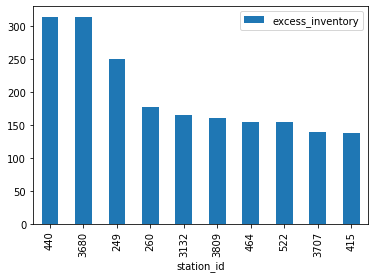

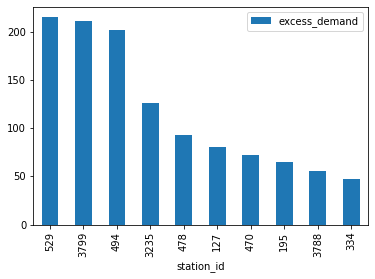

In [15]:
# Insert your code here
from matplotlib.ticker import StrMethodFormatter
joined = starting_inventory.join(demand, lsuffix = '_inventory', rsuffix = '_demand', sort = True)
joined['excess_inventory'] = np.maximum(0, joined['count_inventory'] - joined['count_demand'])
joined.sort_values(by='excess_inventory', ascending=0).head(10).plot.bar(y = 'excess_inventory')
joined['excess_demand'] = np.maximum(0, joined['count_demand'] - joined['count_inventory'])
joined.sort_values(by='excess_demand', ascending=0).head(10).plot.bar(y = 'excess_demand')

# 2. Optimal Rebalancing of Bike Inventory

**Matching supply with demand**: Given the imbalances between demand and inventory, Citibike runs frequent "rebalancing" operations, where bikes are relocated from a dock station having an excess of inventory to a station having insufficient inventory. These rebalancing operations are run in an ad-hoc fashion. You would like to construct an optimization model to rigorously rebalance the inventory before the beginning of the peak hour.

**The economics of rebalancing:** Rebalancing operators have to be paid \\$1 per km per relocated bike. There are no geographical restrictions on the rebalancing of bikes (from any station to any other station). After the rebalancing is performed, the amount of demand satisfied at each station will the minimum between the new inventory level and the demand. Each satisfied user request brings \\$4 of revenue, on average. Hence, when bikes are unavailable and the user request is unfulfilled, Citibike loses the revenue opportunity of \\$4. 

*In what follows, I will formulate and implement the rebalancing problem as an integer program. Starting with the inventory levels of `starting_inventory`, I want to find the bikes relocations that maximize the total net revenue. For simplicity, I can assume that the rebalancing operations happen instantaneously before the beginning of the peak hour.*

In [6]:
# The following lines of code import the gurobi package
import gurobipy as gp
from gurobipy import GRB,quicksum

## Model creation

### 2.1. Create a GUROBI new model "m", named "rebalancing"

In [7]:
m = gp.Model('rebalancing')

Using license file /Users/suzi/gurobi.lic
Academic license - for non-commercial use only


## Decision variables

Clearly the main decisions have to do with the "relocation" of bikes.

In [8]:
# Instantiate the list of all stations
stations = demand.index.tolist()

# Next, we create an "integer" decision variable for each pair of dock stations (A,B)
relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation")

### 2.2. Explain in detail what the code in the cell above is doing.

*The first code is parsing the indeces of the dataset 'demand' and putting the names of the stations into the new dataset named 'stations'. The second code, on the other hand, is creating a decision variable for 'rebalancing' model. This decision variable has the pairs of the stations so that we can gain the exact numbers of the bikes relocated, which helps us to satisfy the objective that is maximising the revenue.*


Let's add auxiliary decision variables which will be needed for the problem. I would suggest the following code.

In [9]:
satisfied_demand = m.addVars(stations,vtype=GRB.INTEGER, lb = 0, name="satisfied_demand")

### But, why are the variables `satisfied_demand` needed? How do we refer to such variables (which do not describe actual decisions)?

*The 'satisfied_demand' is an auxiliary variable that does not directly affect actual decisions but helps solving complex relationship models. This auxiliary variable is needed to set the set the objective and decide upperbound of the number of the bikes that are necessary to be relocated. If we do not set the 'satisfied_demand', we can't calculate the estimated revenue since the revenue is based on the satisfied demand. Thus, by setting auxiliary variable we can set our objective and create legitimate constraint.*


## Constraints

### 2.4. Let's consider the upper bound on the number of bikes that can be relocated from one station to another. 

In [10]:
#The number of bikes that will be relocated can't exceed the existing bikes in the station.
for l1 in stations:
    for l2 in stations:
        m.addConstr(relocation[l1,l2] <= starting_inventory.loc[l1, "count"], name = "upper_bound")

The satisfied demand in each station is the minimum between the demand and the inventory after rebalancing. For example, if station A has 10 bikes before the relocation and we relocate 2 extra bikes, we can satisfy up to 12 users. If the demand at station A is 8, we satisfy all 8 users. If the demand at station A is 15, we can only satisfy 12 users, and we lose 3 user requests. In general, we have the equation:

$$ {\rm satisfiedDemand}(A) ={\rm minimum} \left\{ {\rm Demand}(A), {\rm InventoryAfterRebalancing}(A)\right\}$$

Below, I will add two ensembles of constraints to our model `m` to capture the notion of satisfied demand.

### 2.5. Add constraints imposing that `satisfied_demand` is smaller or equal to the demand, in each station.

In [11]:
upper_bound2 = m.addConstrs(satisfied_demand[l1] <= demand.loc[l1, "count"] for l1 in stations)

### 2.6 Why are the constraints below on the `satisfied_demand` are needed? 

*The constraint below explains that the satisified demand should be lower or equal to the inventory after rebalancing.*


In [12]:
# Additional constraints
m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"] \
              + quicksum(relocation[j,i] for j in stations) -quicksum(relocation[i,j] for j in stations)
                  for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing");

## Objective

### 2.7. Let's formulate the net revenue as a linear expression.

In [13]:
m.setObjective(satisfied_demand.sum()*4 - quicksum(relocation[i,j]*distances.loc[i,j] for i in stations for j in stations), GRB.MAXIMIZE)

## Solve

I have formulated and implemented the integer program. Let's now optimize the rebalancing and printout the optimal revenue

In [14]:
# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 476099 rows, 475410 columns and 1424163 nonzeros
Model fingerprint: 0x724d8759
Variable types: 0 continuous, 475410 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective 62468.000000
Presolve removed 475410 rows and 689 columns
Presolve time: 1.58s
Presolved: 689 rows, 474721 columns, 948753 nonzeros
Variable types: 0 continuous, 474721 integer (40 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -7.5668248e+04      2s
       1        683  -6.9875402e+04  -7.4647049e+04      2s
       2       1590  -7.0968990e+04  -7.3629010e+04      2s
       3       2534  -7.1238091e+04  -7.2201329e+04      2s
       4       3378  -7.1313783e+04  -7.133

### The optimal net revenue

*The optimal revenue I have generated by maximising the profit(= revenue - cost) is £71314.1.* 




### 2.9. Let's calculate how much revenue Citibike gains using the optimal rebalancing compared to no rebalancing.
*The goal here is to quantity how the revenue changes after the optimal rebalancing vs. no rebalancing. To compute the revenue in the absence of rebalancing, I reuse the optimization model with a small modification of the variables `relocation`.*

*The code below set the upper bound of relocatoin to '0' which means that here is no rebalancing. I commented the codes because once I run these codes, the results of the heatmaps given would be distorted.\
The revenue without rebalancing is \\$62,468 as we can see below, so there is $8,846 extra revenue for Citibank after relocation, which increases the revenue by 14%. This increase is very significant.*



In [15]:
# relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, ub = 0, name="relocation")

In [16]:
#for l1 in stations:
#    for l2 in stations:
#        m.addConstr(relocation[l1,l2] <= starting_inventory.loc[l1, "count"], name = "upper_bound")
#        
#upper_bound2 = m.addConstrs(satisfied_demand[l1] <= demand.loc[l1, "count"] for l1 in stations)
#
#m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"] \
#              + quicksum(relocation[j,i] for j in stations) -quicksum(relocation[i,j] for j in stations)
#                  for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing");

In [17]:
#def printSolution():
#    if m.status == GRB.OPTIMAL:
#        print('\nNet revenue: %g' % m.objVal)
#    else:
#        print('No solution:', m.status)
#        
#m.optimize()
#printSolution()

### This is the answer for the codes above after the slight change of decision variable "relocation" by amending upper bound.
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1426919 rows, 1899573 columns and 3323047 nonzeros
Model fingerprint: 0x179f2b92
Variable types: 0 continuous, 1899573 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint satisfied_demand_vs_inventory_after_rebalancing[127] by 80.000000000

Found heuristic solution: objective 62468.000000
Presolve removed 1426230 rows and 1424892 columns
Presolve time: 2.30s
Presolved: 689 rows, 474681 columns, 948713 nonzeros
Variable types: 0 continuous, 474681 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 3.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 62468 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.246800000000e+04, best bound 6.246800000000e+04, gap 0.0000%

Net revenue: 62468

The relocations are visualized on the heatmap in the next cell.

In [55]:
from collections import namedtuple
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing
def get_arrows(locations, color='black', size=4, n_arrows=3,opacity = 1):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, color = color, number_of_sides=3, 
                      radius=size, rotation=rotation,opacity = opacity))
    return arrows

base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance between demand and inventory
imbalance = np.maximum(0,demand_agg-inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list, radius=12, max_zoom=15).add_to(base_map)

#Displays the map
base_map       

### 2.10. Let's interpret the plot.

*The plot I've gotten is what I have expected. Majority of the relocations were performed towards the city centre, which makes sense. If I point one case, the bikes are moving from Brooklyn, where there are excess supplies to downtown NY, where there are excess demands.* 

# 3. Rebalancing with replenishment

Let's say my manager has a concern about your analysis in 2.Optimal Rebalancing of Bike Inventory:

*I like the idea of rebalancing bikes based on an optimization model. However, I have omitted an important aspect of the problem. When a user completes her current trip, she returns the bike to the system. A new bike is made available at the destination station. I don't account for this in my current inventory, but this organic replenishment of bikes might be very helpful since it increases the number of bikes available at the destination station!*

The goal of 3.Rebalancing with replenishment is to update the model accordingly. I will reuse most of the existing code, with minor modifications. My analysis will be based on the following additional data set:

- `replenishment.csv`: describes the number of extra bikes that will be made available at each station after current users complete their trips. 

**For simplicity, we will assume that the replenishment happens instantaneously before the beginning of the peak hour.**

### 3.1. Based on the manager's comment, did we under-estimate or over-estimate the inventory at each station in the previous part 2?

*We underestimated the inventory because we did not take the bikes that would arrive to the station into account.* 


## Loading the data

In [26]:
replenishment = pd.read_csv("replenishment.csv", index_col=0)

*Visualize the replenishment data.*

In [48]:
replenishment.describe()

,latitude,longitude,count
count,689.000000,689.000000,689.000000
mean,9.869376,-17.764877,6.513788
std,1.136245,2.045241,11.240249
min,0.000000,-18.000000,0.000000
25%,10.000000,-18.000000,1.000000
50%,10.000000,-18.000000,3.000000
75%,10.000000,-18.000000,7.000000
max,10.000000,0.000000,108.000000


In [27]:
replenishment.head()

,latitude,longitude,count
station_id,,,
119,10,-18,1
120,10,-18,2
127,10,-18,42
143,10,-18,3
144,10,-18,1


## Model creation

### 3.2. Create the model object

In [28]:
m = gp.Model('replenishment')

## Decision variables

### 3.3. Add the decision variables to `m`

In [29]:
# Instantiate the list of all stations
stations = demand.index.tolist()

# Next, we create an "integer" decision variable for each pair of dock stations (A,B)
relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation")
satisfied_demand = m.addVars(stations,vtype=GRB.INTEGER, lb = 0, name="satisfied_demand")

## Constraints

### 3.4. Add an upper bound on the number of bikes that can be relocated from one station to another.

In [30]:
for l1 in stations:
    for l2 in stations:
        m.addConstr(relocation[l1,l2] <= starting_inventory.loc[l1, "count"], name = "upper_bound")

### 3.5. Add constraints requiring that `satisfied_demand` is smaller or equal to the demand.

In [31]:
upper_bound2 = m.addConstrs(satisfied_demand[l1] <= demand.loc[l1, "count"] for l1 in stations)

 ### 3.6. The `satisfied_demand` should be also be related to inventory. I should modify the constraint of 2.6. to account for replenishment. Let's add these constraints into the model.
 
 *For simplicity, I can assume that all the replenishment happens before the demand arrives. This assumption is reasonable since the system is "stationary".*

In [32]:
m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"] \
              + quicksum(relocation[j,i] for j in stations) - quicksum(relocation[i,j] for j in stations)\
              + replenishment.loc[i, "count"] for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing");

## Objective

### 3.7. Specify the objective of the model `m`

In [33]:
m.setObjective(satisfied_demand.sum()*4 - quicksum(relocation[i,j]*distances.loc[i,j] for i in stations for j in stations), GRB.MAXIMIZE)

## Solve

I have formulated and implemented the integer program. Let's now optimize the rebalancing and printout the optimal revenue.

In [34]:
# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 476099 rows, 475410 columns and 1424163 nonzeros
Model fingerprint: 0x038c520c
Variable types: 0 continuous, 475410 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Found heuristic solution: objective 72024.000000
Presolve removed 475410 rows and 689 columns
Presolve time: 1.28s
Presolved: 689 rows, 474721 columns, 948753 nonzeros
Variable types: 0 continuous, 474721 integer (40 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -7.6042840e+04      2s
       1        193  -7.5585959e+04  -7.5823546e+04      2s

Sifting complete


Root relaxation: objective 7.566290e+04, 378 iterations, 0.24 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work

### 3.7. Read the output of the optimization: Confirm if the optimal net revenue is greater or smaller than that obtained without replenishment in part2.

*The net revenue has increased after taking the replenishment into consideration. We get higher revenue because now we are able to move less bikes than before since users are moving bikes which helps us not paying any extra cost for moving the bikes.* 



### 3.8. Check how much revenue Citibike gains using the optimal rebalancing compared to no rebalancing and compare the result with part2 (w/o replenishment).
*The goal here is to quantity the revenue change after vs. before the optimal rebalancing. To compute the revenue in the absence of rebalancing, I could reuse our optimization model with a very small modification of the variables `relocation`.*

*The codes below show the revenue of Citibike without rebalancing the bikes. Compared to the revenue of \\$62,468 from part 2.9., the revenue of Citibike gaining without rebalancing now is much higher with the revenue of \\$72,024. This is because even though the Citibike did not relocate the bikes by themselves, it took the replenishment variable into account. The constraints for the 'satisfied_demand' variable was coordinated by replenishment dataset and it was adjusted by the objective function which involves 'satisfied_demand' variable.* 


In [35]:
#relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, ub = 0, name="relocation")

In [36]:
#for l1 in stations:
#    for l2 in stations:
#        m.addConstr(relocation[l1,l2] <= starting_inventory.loc[l1, "count"], name = "upper_bound")
#       
#upper_bound2 = m.addConstrs(satisfied_demand[l1] <= demand.loc[l1, "count"] for l1 in stations)
#
#m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"] \
#              + quicksum(relocation[j,i] for j in stations) -quicksum(relocation[i,j] for j in stations)\
#              + replenishment.loc[i,"count"] for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing");

In [37]:
#def printSolution():
#    if m.status == GRB.OPTIMAL:
#        print('\nNet revenue: %g' % m.objVal)
#    else:
#        print('No solution:', m.status)
#        
#m.optimize()
#printSolution()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 952198 rows, 950131 columns and 2848326 nonzeros
Model fingerprint: 0x4dbe9654
Variable types: 0 continuous, 950131 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint satisfied_demand_vs_inventory_after_rebalancing[127] by 38.000000000

Found heuristic solution: objective 72024.000000
Presolve removed 951509 rows and 475450 columns
Presolve time: 1.85s
Presolved: 689 rows, 474681 columns, 948713 nonzeros
Variable types: 0 continuous, 474681 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 2.46 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 72024 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.202400000000e+04, best bound 7.202400000000e+04, gap 0.0000%

Net revenue: 72024

The relocations are visualized on the heatmap in the next cell.

In [38]:
base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance between demand and inventory
imbalance = np.maximum(0,demand_agg-inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list, radius=12, max_zoom=15).add_to(base_map)

#Displays the map
base_map                

### 3.9. Interpretation of the plot comparing with part 2.10.

*Since we took the replenishment into account, we can visually see that there are much less relocations than that of part 2.10. The arrows are drawn toward the city center, Manhattan downtown, the density of the arrows are much more sparse than before, which indicates that the new variable - replenishment - has decreased significant amount of cost for the relocation.* 



# 4. Vehicle Capacity

In reality, Citibike can utilize two types of vehicles:
- Large capacity vehicles (LCV): These are the default vehicles. They can carry any arbitrary number of bikes. Due to the large size of the vehicle, rebalancing operators have to be paid \\$1 per km per relocated bike (similar to part 2 and 3).
- Small capacity vehicles (SCV): These specialized vehicles can handle up to 10 bikes per rebalancing operation. Rebalancing operators have to be paid \\$0.5 per km per relocated bike.

For each relocation operation (corresponding to a pair of stations), the firm needs to choose exactly one type of vehicle. The goal of part 4 is to update the model constructed in part 3 to incorporate the following logical condition: *EITHER we use a small capacity vehicle and the number of relocated bikes is less than 10 OR we use a large capcity vehicle*.

## Decision variables: Small vs. large vehicles

We add relocation variables corresponding to the use of small vs. large vehicles.

In [39]:
# The decision variable describe the number of bikes relocated from station A to station B
relocation_SCV = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation_small")
relocation_LCV = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation_large")

## Constraints

In the next constraint, we impose that the total number of relocations is the sum of relocations using SCVs and LCVs.

In [40]:
m.addConstrs(relocation[i,j] == relocation_SCV[i,j] + relocation_LCV[i,j] for i in stations for j in stations);

### 4.1. Add constraints requiring that EITHER we use an SCV with at most 10 bikes OR we don't use an SCV 
*Let's use the big-M method and define a binary auxiliary variable for each pair of stations to switch between the two conditions.*

In [41]:
M = 100000
auxiliary = m.addVars(stations,stations,vtype=GRB.BINARY, name="OR_auxiliary")
m.addConstrs(relocation_SCV[i,j] <=  10 + M*(1-auxiliary[i,j]) for i in stations for j in stations)
m.addConstrs(relocation_SCV[i,j] <=  0 + M*auxiliary[i,j] for i in stations for j in stations)

{(119, 119): <gurobi.Constr *Awaiting Model Update*>,
 (119, 120): <gurobi.Constr *Awaiting Model Update*>,
 (119, 127): <gurobi.Constr *Awaiting Model Update*>,
 (119, 143): <gurobi.Constr *Awaiting Model Update*>,
 (119, 144): <gurobi.Constr *Awaiting Model Update*>,
 (119, 146): <gurobi.Constr *Awaiting Model Update*>,
 (119, 150): <gurobi.Constr *Awaiting Model Update*>,
 (119, 157): <gurobi.Constr *Awaiting Model Update*>,
 (119, 161): <gurobi.Constr *Awaiting Model Update*>,
 (119, 167): <gurobi.Constr *Awaiting Model Update*>,
 (119, 173): <gurobi.Constr *Awaiting Model Update*>,
 (119, 174): <gurobi.Constr *Awaiting Model Update*>,
 (119, 195): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2000): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2002): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2003): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2005): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2009): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2012): <gurobi.C

## Objective

The objective function is modified accordingly. 

In [42]:
# Set the objective: maximize the net revenue
m.setObjective(4*satisfied_demand.sum()
               -1*quicksum(relocation_LCV[i,j]*distances.loc[i,j] for i in stations for j in stations)
               -0.5*quicksum(relocation_SCV[i,j]*distances.loc[i,j] for i in stations for j in stations)               
               ,GRB.MAXIMIZE)

## Solve

I have finally formulated and implemented the integer program. Let's now optimize the rebalancing and printout the optimal revenue.

In [43]:
# Run the optimization
# It is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
        
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1900262 rows, 1899573 columns and 4747210 nonzeros
Model fingerprint: 0xa34044ea
Variable types: 0 continuous, 1899573 integer (474721 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [7e-05, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]

MIP start from previous solve produced solution with objective 75806.8 (3.05s)
Loaded MIP start from previous solve with objective 75806.8
Processed MIP start in 3.16 seconds

Presolve removed 1350549 rows and 1058836 columns (presolve time = 6s) ...
Presolve removed 1716565 rows and 1241844 columns
Presolve time: 8.68s
Presolved: 183697 rows, 657729 columns, 1314769 nonzeros
Variable types: 0 continuous, 657729 integer (40 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

The relocations are visualized on the heatmap in the next cell. *Execute the next cell.*

In [45]:
base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance between demand and inventory
imbalance = np.maximum(0,demand_agg-inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list, radius=12, max_zoom=15).add_to(base_map)

#Displays the map
base_map                

### 4.2. Compare the output with part 3.7- 3.9 and explain wether the net revenue changes.

*The net revenue has increased after dividing the decision variable into two and introducing new constraint with big M technique from \\$72,024 to \\$75,887.3, which makes sense in terms of considering another factor (vehicle size) that could decrease the potential cost.* 



# 5. Critique of the Analysis

**The following part is rather qualitative comments.**

### 5.0.
**What are the main limitations of our current modeling approach? What other aspects of the rebalancing should we account for?**

*The current model has introduced several constraints that could improve the first model we had. However, there are still various real-world factors that have not been captured by our model. \
Firstly, for instance, the absolute numeric distance does not guarantee the time taken for the relocation because the 1km distance in Manhattan might be significantly different from that in New Jersey or Brooklyn. In real world, the cost of relocating bike is calculated not only by the distance between the locations but also by the consumed time. Furthermore, it is not clearly stated which measurement was used for the distance between the bike stations. If it's Euclidean distance, it will not precisely capture real-world road situation between the stations. Even though the absolute distance is 1km, the road could be more than 1km. \
Secondly, if the operations can't be processed in an hour, this whole model can't be used. Thus, the model also needs to consider the road traffics to make sure that the relocation can be done in predetermined time. To improve the model we can add one more constraint to set the upperbound of predicted time taken for the relocation and time can be set as (distance * available speed). Also, we could introduce new data of traffics at certain peak hours to calculate the available speed.\
Finally, the replenishment dataset is based on the prediction, thus we are not sure that the actual customers will return the bike to the predicted destination or not. If we use mis-predicted data, we might actually drop the revenue rather than making it. Thus, we need to have a precise prediction model to apply the replenishment not to lose the money, and should weigh the balance between the accuracy of the model and predicted revene increase carefully.* 

### 5.1. 
**In reality, we don't know in advance the exact number of user request in the next hour. How could we remedy this issue?**

*Considering what we have proceeded so far, we can predict the approximate number of user request by running a machine learning models with the values from the past. Even though it would not be 100% accurate, we can still increase revenue by predicting bike demands. The peak hours are quite fixed over the time, However, we also need to take special city events, disastsers, weathers into the consideration as well. \
In terms of the operational remedy, I would introduce subscription model for the people who use the bike periodically. The customers will be able to set the time and the day that they are planning to use the bike and we can motivate the customers to subscribe by guaranteeing that there will be a bike for them everytime they want and also by providing price discount.* 


### 5.2.
Let's say one of my colleagues has further concerns about how the demand is estimated: *Our historical data only records the customers who are satisfied and complete their trip. Many of our potential customers walk out without even taking a bike!* 

**Is this an important issue? Are we currently over-estimating or under-estimating the value of rebalancing? Let's see how we can deal with this claim.**

*Here could have been uncaptured demands since the data was collected before the rebalancing solution. Many of the potential customers might have passed by the station without taking anything just because there were no bikes at all. Thus, we need to consider the fact that since the solution hasn't been implemented, some uncaptured demand would still exist in the model. To cope with this problem, we can perform the survey towards the customers to collect the data about frustrations they have experienced and tackle the problem by adding those numbers into the demand variable.* 



### 5.3. 
In practice, rebalancing is not an easy operation (see the picture below). It requires to hire specialized labor and rent trucks.

<img src="citi-bike-truck.jpg" width="500">

**What other aspects can be incorporated into the optimization model to make it more realistic?**

To make the model more realistic, we can consider different factors like below:\
1) New users or leavers of the services to better estimate the number of demand\
2) Paritcular events (e.g. Marathon or Christmas), weather (e.g. rain), season (e.g. winter or summer), or disaster (e.g. earthquake) that can hugely impact the demand of the bikes\
3) The probability of bike being stolen or broken by certain areas\
4) The popular routes (e.g. Times Square to Battery Park) that could help predicting the estimated inventories in certain stations

### 5.4. 
**For which other operational decisions could Citibike utilize optimization models?**

*As I mentioned above, the Citibike can utilize optimization models to decide how many time they should relocate the bike in a day with maximising the bikes cargoed in the large capacity vehicle. Since every relocation travel costs the money, Citibike should aim the maximum efficiency for every driving for the relocation.\
Also, Citibike can open the new stations or close the existing one according to the imbalance between the demand and supply. If Citibike can increase their revenue by getting rid of or opening new stations, definitely optimization models will be used for that.\
Finally, the quality management could be also processed more economically by optimizing the route of the inspectors using Travel Salesman Problem and by optimizing the expected loss and cost coming from the disappointment of customers who used misqualified and ruined credibility.*